This notebook performs LSTM using the feature indicated from principle component analysis

In [1]:
using Pkg

In [2]:
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy
using StatsBase: wsample
using Base.Iterators: partition
using CSV
using MultivariateStats
using LinearAlgebra
using StatsBase
using Random
using BSON: @save
using Dates
using Plots
using Statistics
using DataFrames

loaded


In [3]:
BIN_STEP = .0001;
N_FEATURES = 1;
ALPHABET_SIZE = 200;

In [4]:
add_dim(x::Array,dim) = reshape(x, (size(x)...,1))

add_dim (generic function with 1 method)

In [5]:
prctile(x::Array,p) = sort(x)[Int(round((p/100)*length(x)))]

prctile (generic function with 1 method)

In [6]:
text = CSV.read("f1_processed_data.csv", header=0);
text = convert(Array, text);
timepts = text[:,1];
heel_strike = findall(text[:,8].==1);


cycle_time = heel_strike[2:end] .- heel_strike[1:end-1];
startPF = Int.(round.(heel_strike[1:end-1] .+ .3 .*cycle_time .- 15));
PFend = Int.(round.(heel_strike[1:end-1] .+ .6 .*cycle_time));

labels = text[:,end];
data0 = text[:,[2,3,4,5,6,7]];

SOS = 1.1;
EOS = 99.9;

means = [mean(data0[:,col]) for col in range(1,size(data0,2))];
std_data = [std(data0[:,col]) for col in range(1,size(data0,2))];
means = reshape(means,(1,6));
data0 = data0 .-means;
data0 = data0 ./ reshape(std_data, (1,6));

In [7]:
function customPCA(dat, num_components)
    V = StatsBase.cov(dat);
    values = eigvals(V)
    vectors = eigvecs(V)
    
    k = sortperm(values,rev=true)
    k_keep = k[1:num_components]
    data_proj = transpose(vectors[:,k_keep])*transpose(dat)
    return values, vectors, data_proj, k_keep
end

customPCA (generic function with 1 method)

In [9]:
values, vectors, data_proj, k_keep = customPCA(data0, 1);

[0.70826, 0.741365, 0.873613, 1.07571, 1.20189, 1.39915]
[6]


In [10]:
data = data0[:,k_keep];

mins_f = minimum(data)
BIN_STEP = (maximum(data_proj) - minimum(data_proj))./ALPHABET_SIZE
data = (round.((data .- mins_f)./BIN_STEP)) .+ 1;

st_idx = 1;
seqlens = [];
data_old = Array{Float64}(undef, 0, N_FEATURES)
data_stride = [];
data_stride_y = [];

tst_data_stride = [];
tst_data_stride_y = [];

alphabet = unique(data);
append!(alphabet, [SOS EOS])
data_a = map(ch -> onehot(ch, alphabet), data);
stop_idx = onehot(SOS, alphabet);

# randomize strides
sf_inds = shuffle(1:length(PFend));

data_add = [];
for i in sf_inds
    global data_add, data_n
#     # section data one way with data_n
#     global data_n
     data_n = data[st_idx:startPF[i],:]
    
     data_n=vcat(data_n, reshape(repeat([SOS],(N_FEATURES)),(1,N_FEATURES)))
     data_n = vcat(data_n, data[startPF[i]+1:PFend[i],:])
     data_n=vcat(data_n, reshape(repeat([EOS],(N_FEATURES)),(1,N_FEATURES)))
     data_n = [data_old; data_n]
     if i == length(startPF)
         data_n = [data_n; data[PFend[i]:end,:]];
     end
     data_old = copy(data_n)
    st_idx = PFend[i] +1
    if i > 1
        data_add = data_n[PFend[i-1]:PFend[i]];
#         data_add = map(ch -> reshape(onehot(ch, alphabet),(length(alphabet),1)), data_add)
        
        append!(seqlens, length(PFend[i-1]:PFend[i]))
        
        # section data a different way with data_stride
        
        if i > round(.8*length(PFend))
            append!(tst_data_stride, [data_add])
            append!(tst_data_stride_y, [data_add[2:end]])
        else
            append!(data_stride, [data_add])
            append!(data_stride_y, [data_add[2:end]])
        end
    end
    
end
# data_OH = map(ch -> onehot(ch, alphabet), data_n);


In [11]:
function custom_pad(data, seqlen, pad)
    dnew = [];
    for dat in data
        if length(dat)<seqlen
#             println(fill(seqlen-length(dat), pad))
            append!(dat, fill(pad,seqlen-length(dat)));
        end
        dat = dat[1:seqlen]
        
        datn = map(ch -> reshape(onehot(ch, alphabet),(length(alphabet),1)), dat)
        append!(dnew, [datn])
    end
    return dnew
end

custom_pad (generic function with 1 method)

In [12]:
seqlen = prctile(seqlens,75);
stop_idx = onehot(SOS, alphabet);

data_strideOH = custom_pad(data_stride, seqlen, SOS);
data_stride_yOH = custom_pad(data_stride_y, seqlen, SOS);
tst_data_stride_yOH = custom_pad(tst_data_stride_y, seqlen, SOS);
tst_data_strideOH = custom_pad(tst_data_stride, seqlen, SOS);

In [13]:
using Flux: @epochs

N = length(alphabet)

m = Chain(
#   Conv((3,1), 6=>1, relu),
#   x -> maxpool(x, (3,1)),
  LSTM(N, 128),
  LSTM(128, 128),
  Dense(128, N),
  softmax)

m = gpu(m)

function loss(xs, ys)
  l = sum(crossentropy.(m.(gpu.(xs)), gpu.(ys)))
  Flux.truncate!(m)
  return l
end

opt = ADAM(params(m), 0.01)

tst_idx = sample(1:length(tst_data_strideOH),1)[1];
tx, ty = (gpu.(data_strideOH[tst_idx]), gpu.(data_stride_yOH[tst_idx]))
tstx, tsty = (gpu.(tst_data_strideOH[tst_idx]), gpu.(tst_data_stride_yOH[tst_idx]))

loss_vec= [];
test_loss_vec = [];
evalcb = throttle(30) do
    @show "Train Loss" loss(tx, ty)
    @show "Test Loss" loss(tstx, tsty)
    append!(loss_vec, loss(tx, ty))
    append!(test_loss_vec, loss(tstx, tsty))
#     @save "BestPC-model.bson" m opt
end


@epochs 5 Flux.train!(loss, zip(data_strideOH, data_stride_yOH), opt,
            cb = throttle(evalcb, 2))

@save "BestPC-model1212.bson" m opt
# CSV.write("BestPC_trainloss.csv",DataFrame(loss_vec))
# CSV.write("BestPC_testloss.csv",DataFrame(test_loss_vec))

using JLD
save("BestPC_lr01Vars_1212.jld", "test_data", tst_data_stride_OH, "labels",tst_data_stride_yOH,"alphabet", alphabet)

# Sampling
m = cpu(m)


┌ Info: Epoch 1
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
loss(tx, ty) = 833.4159970978292 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 837.430145947502 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 791.78861534444 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 576.5674243294433 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 783.1455714553207 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 578.9501458312168 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 763.4655987416929 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 540.6536547264783 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 695.5450935967316 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 466.1956263745314 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 663.3178055344484 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 420.98562291150915 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 611.5409130301035 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 341.80744776037744 (tr

┌ Info: Epoch 2
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
loss(tx, ty) = 354.79620788415355 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 238.11249397380436 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 344.3766039905002 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 225.29752968538784 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 371.63144730077727 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 232.97800860030566 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 360.6895326760655 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 230.56008596725425 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 354.9884667762991 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 221.1450488067414 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 362.2752820978941 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 232.96359214876244 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 369.3801543134304 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 222.193490824

┌ Info: Epoch 3
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
loss(tx, ty) = 330.5229610958021 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 218.97668198220148 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 308.4753031957238 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 219.7210837109114 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 309.64990176710256 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 214.62551005678466 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 325.1391921536735 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 207.69803719198904 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 329.537534883715 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 202.36789899810543 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 315.28336027211026 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 207.4857639194525 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 326.8809976198703 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 205.85478484989

loss(tstx, tsty) = 211.4852846988245 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 331.0573313104807 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 212.91480842134527 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 329.9404268031986 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 211.61190683046996 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 331.1070349700995 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 209.7626278856121 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 328.67702534954117 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 208.3818319530605 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 323.8590237683516 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 209.74195963438876 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 323.4566693218582 (tracked)
"Test Loss" = "Test Loss"
loss(tstx, tsty) = 210.64215365574802 (tracked)
"Train Loss" = "Train Loss"
loss(tx, ty) = 323.31446730420544 (tracked)
"Test Loss" 

InterruptException: InterruptException:

In [22]:
# @save "BestPC-model1212.bson" m opt
# CSV.write("BestPC_trainloss.csv",DataFrame(loss_vec))
# CSV.write("BestPC_testloss.csv",DataFrame(test_loss_vec))

using JLD
save("BestPC_lr01Vars_1213.jld", "test_data", tst_data_strideOH, "labels",tst_data_stride_yOH,"alphabet", alphabet)



HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5Tfields.c line 60 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5Tfields.c line 60 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5Tfields.c line 60 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type
HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5Tfields.c line 60 in H5Tget_nmembers(): not a datatype
    major: Invalid arguments to routine
    minor: Inappropriate type


ErrorException: Error getting the number of members

In [20]:
save("BestPC_lr01Vars_1213_noOneHot.jld", "test_data_noOH", tst_data_stride, "labels_noOH",tst_data_stride_y)

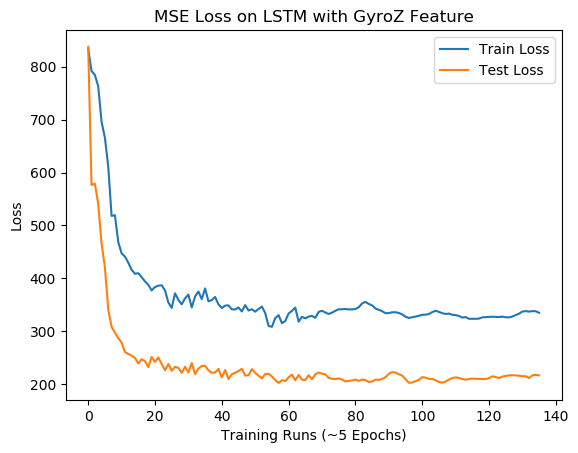

PyObject <matplotlib.legend.Legend object at 0x12f4654a8>

In [19]:
using PyPlot
# loss_vec = [l.data for l in loss_vec]
# test_loss_vec = [t.data for t in test_loss_vec];
PyPlot.plot(loss_vec, label = "Train Loss")
PyPlot.plot(test_loss_vec, label= "Test Loss")
xlabel("Training Runs (~5 Epochs)")
ylabel("Loss")
title("MSE Loss on LSTM with GyroZ Feature")
legend(loc="upper right",fancybox="true")

In [21]:
function sample_fun(m, alphabet, primer, len; temp = 1)
  Flux.reset!(m)
  buf = []
  c = primer
  for i = 1:len
    append!(buf,c)
    c = wsample(alphabet, m(onehot(c, alphabet)).data)
  end
  return buf
end

avail_samples = collect(1:length(tst_data_stride));
buffer = [];
s_order = [];
while length(avail_samples)>1
    sample_idx = sample(1:length(tst_data_stride));
    append!(buffer, [sample_fun(m, alphabet, tst_data_stride[sample_idx][1], length(tst_data_stride[sample_idx]))]);
    setdiff!(avail_samples, sample_idx)
    append!(s_order, sample_idx)
end

In [15]:
using Plots

In [16]:
recon_data = buffer[1]

plot(recon_data[:,1])
plot!(recon_data[:,2])
plot!(recon_data[:,3])
plot!(recon_data[:,4])
plot!(recon_data[:,5])
plot!(recon_data[:,6])

BoundsError: BoundsError: attempt to access 181-element Array{Any,1} at index [Base.Slice(Base.OneTo(181)), 2]

In [17]:
recon_data_true = data

plot(recon_data_true[:,1])
plot!(recon_data_true[:,2])
plot!(recon_data_true[:,3])
plot!(recon_data_true[:,4])
plot!(recon_data_true[:,5])
plot!(recon_data_true[:,6])

BoundsError: BoundsError: attempt to access 90332×1 Array{Float64,2} at index [Base.Slice(Base.OneTo(90332)), 2]

In [18]:
plt1 = plot(0, recon_data_true[1,5])
plt2 = plot(0, recon_data[1,5])
# for i in size(recon_data_true,1)-1
timevec = collect(0:10:size(recon_data,1)/10);
for i in 1:10
    push!(plt1, timevec[i], x, recon_data_true[i])
    push!(plt2, timevec[i], x, recon_data[i])
    gui(); sleep(0.5)
end
        

BoundsError: BoundsError: attempt to access 90332×1 Array{Float64,2} at index [1, 5]

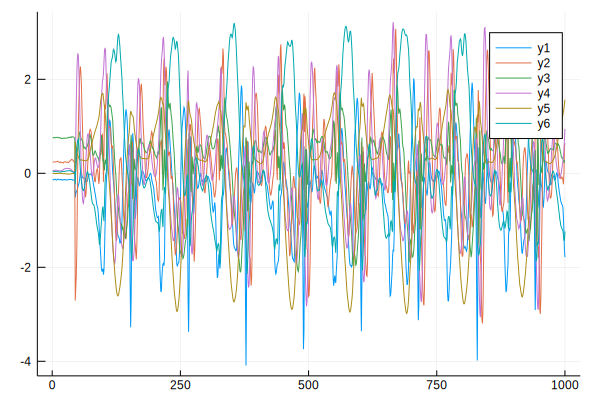

In [19]:
plot(data0[1:1000,1])
plot!(data0[1:1000,2])
plot!(data0[1:1000,3])
plot!(data0[1:1000,4])
plot!(data0[1:1000,5])
plot!(data0[1:1000,6])